In [1]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=f1bcab9b4dc855a5a18f2ad085804ef9c0f215f06bb5fa128bf8d779716dd37e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [2]:
import os
import pickle
import datetime

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import dill
import json

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose

import google.colab
from google.colab import files

import time

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1: Cargando los datos

In [116]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [117]:
labels_names = {
    0: "T-Shirt",    # Remera manga corta
    1: "Trouser",    # Pantalon
    2: "Pullover",   # Buzo
    3: "Dress",      # Vestido
    4: "Coat",       # Abrigo
    5: "Sandal",     # Sandalia
    6: "Shirt",      # Remera manga larga
    7: "Sneaker",    # Zapatilla
    8: "Bag",        # Bolso
    9: "Ankle Boot", # Bota
}

## 2: Creando un `DataSet` personalizado.

In [118]:
# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

In [119]:
# Convertimos FashionMNIST Dataset a CustomDataset para 
trainset = CustomDataset(trainset)
testset = CustomDataset(testset)

## 3: Creando el Autoencoder

In [120]:
class Autoencoder(nn.Module):
    def __init__(self,n, p=0.1):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,n),
            nn.Dropout(p),
            nn.ReLU(),
            nn.Linear(n,28*28),
            nn.Dropout(p),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

## 4: Entrenando el modelo

In [122]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_train_loss = 0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Seteamos el modelo en modo entrenamiento. Esto sirve para activar, por ejemplo, dropout, etc. durante la fase de entrenamiento
    model.train()
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Movemos el lote a la GPU
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_batch = loss.item()
        sum_train_loss += loss_batch
        if batch*batch_size % 5000 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_train_loss = sum_train_loss/num_batches
    return avg_train_loss

# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    # Definimos ciertas constantes  
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_test_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Movemos el lote a la GPU
            X,y = X.to(device),y.to(device)          
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            loss_batch = loss_fn(pred,y).item()
            sum_test_loss += loss_batch
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            # sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_test_loss = sum_test_loss/num_batches
    # frac_correct = sum_correct/size
    # print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    print(f"Test Error: Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss

In [123]:
# Definimos
learning_rate = 1
batch_size = 1000
# n = 64
# model = Autoencoder(n)

In [124]:
# Creamos los DataLoaders
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

In [127]:
def func(L):
    model = Autoencoder(L)
    trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)
    #loss_fn = nn.CrossEntropyLoss()  # Para clasificación
    loss_fn = nn.MSELoss()            # Para autoencoder
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)                                            #SGD
    #optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)   #Adam
    num_epochs = 50
    list_avg_train_loss = []
    list_avg_test_train_loss = []
    list_avg_test_loss = []

    ####
    start = time.perf_counter()
    print("El tiempo está siendo calculado")
    ####

    print(f"L= {L}\n------------------------------------------")

    for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}\n------------------------------------------")
      avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)  # error promedio a medida que va entrenando (este NO SE GRAFICA)
      avg_test_train_loss = test_loop(trainloader,model,loss_fn)        # error promedio una vez que ya entreno todas las epocas
      avg_test_loss = test_loop(testloader,model,loss_fn)               # error promedio luego de testear
      list_avg_train_loss.append(avg_train_loss)
      list_avg_test_train_loss.append(avg_test_train_loss)
      list_avg_test_loss.append(avg_test_loss)
    
    print("Done!")

    ####
    end = time.perf_counter()
    print("El tiempo de ejecución fue", end - start)
    print("")
    ####

    return list_avg_test_train_loss, list_avg_test_loss

In [128]:
L = [64,128,256,512]

In [129]:
lists = [func(n) for n in L]

This time is being calculated
L= 64
-------------------------------
Epoch 1
-------------------------------
batch=0 loss=0.182571  muestras-procesadas:[    0/60000]
batch=5 loss=0.164149  muestras-procesadas:[ 5000/60000]
batch=10 loss=0.151049  muestras-procesadas:[10000/60000]
batch=15 loss=0.140904  muestras-procesadas:[15000/60000]
batch=20 loss=0.134836  muestras-procesadas:[20000/60000]
batch=25 loss=0.135058  muestras-procesadas:[25000/60000]
batch=30 loss=0.129738  muestras-procesadas:[30000/60000]
batch=35 loss=0.125525  muestras-procesadas:[35000/60000]
batch=40 loss=0.124996  muestras-procesadas:[40000/60000]
batch=45 loss=0.122273  muestras-procesadas:[45000/60000]
batch=50 loss=0.118243  muestras-procesadas:[50000/60000]
batch=55 loss=0.118743  muestras-procesadas:[55000/60000]
Test Error: Avg loss: 0.102682 

Test Error: Avg loss: 0.102536 

Epoch 2
-------------------------------
batch=0 loss=0.115203  muestras-procesadas:[    0/60000]
batch=5 loss=0.114529  muestras-pro

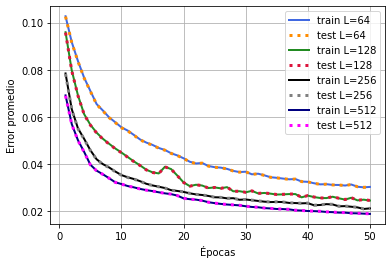

In [130]:
plt.xlabel('Épocas')
plt.ylabel('Error promedio')

plt.plot(list(range(1,len(lists[0][0])+1)),lists[0][0],label=f"train L={L[0]}",linestyle='-',linewidth=2.0,c='royalblue')
plt.plot(list(range(1,len(lists[0][0])+1)),lists[0][1],label=f"test L={L[0]}",linestyle=':',linewidth=3.0,c='darkorange')
plt.plot(list(range(1,len(lists[0][0])+1)),lists[1][0],label=f"train L={L[1]}",linestyle='-',linewidth=2.0,c='forestgreen')
plt.plot(list(range(1,len(lists[0][0])+1)),lists[1][1],label=f"test L={L[1]}",linestyle=':',linewidth=3.0,c='crimson')
plt.plot(list(range(1,len(lists[0][0])+1)),lists[2][0],label=f"train L={L[2]}",linestyle='-',linewidth=2.0,c='black')
plt.plot(list(range(1,len(lists[0][0])+1)),lists[2][1],label=f"test L={L[2]}",linestyle=':',linewidth=3.0,c='grey')
plt.plot(list(range(1,len(lists[0][0])+1)),lists[3][0],label=f"train L={L[3]}",linestyle='-',linewidth=2.0,c='navy')
plt.plot(list(range(1,len(lists[0][0])+1)),lists[3][1],label=f"test L={L[3]}",linestyle=':',linewidth=3.0,c='magenta')

plt.title('')
plt.legend()
plt.grid()
plt.savefig('fig:sgc-completo-50_epocas.pdf', dpi=600, format='pdf')